In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from skimage import io
from PIL import Image, ImageFile
import pandas as pd
import os
import json
from torch.optim import lr_scheduler
from tqdm import tqdm_notebook
from sklearn.metrics import cohen_kappa_score, accuracy_score
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir, transform=None):
        self.df = df_data
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]

        img_path = os.path.join(self.data_dir, f"{image_id}.png")
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
test_csv = pd.read_csv('/content/drive/MyDrive/DR_Project/input/test.csv')
test_path = "/content/drive/MyDrive/DR_Project/input/test_images"
test_csv['diagnosis'] = -1


In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

test_dataset = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, 5),
    nn.LogSoftmax(dim=1)
)

model.to(device)

# Freeze/unfreeze layers
for name, child in model.named_children():
    if name in ['layer2', 'layer3', 'layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

criterion = nn.NLLLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def load_model(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model

model = load_model("/content/drive/MyDrive/DR_Project/models/new_classifier.pt")


In [ ]:
def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
        if pred < coef[0]:
            preds[i] = 0
        elif pred < coef[1]:
            preds[i] = 1
        elif pred < coef[2]:
            preds[i] = 2
        elif pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds


In [ ]:
with torch.no_grad():
    model.eval()
    p_labels = []
    img_ids = []
    i = 0

    for inputs, labels in test_loader:
        i += 1
        if i % 10 == 0:
            print(f'{i} pass step')

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        p_labels.append(preds.cpu())


10 pass step
20 pass step
30 pass step
40 pass step
50 pass step
60 pass step


In [ ]:
pred_labels = []
for batch in p_labels:
    for pred in batch:
        pred_labels.append(pred.item())


In [ ]:
sample_sub = pd.read_csv('/content/drive/MyDrive/DR_Project/input/sample_submission.csv')
sample_sub.diagnosis = pred_labels
sample_sub.to_csv('submission.csv', index=False)


In [ ]:
def test_with_single_image(model, file, transform, classes):
    file = Image.open(file).convert('RGB')
    img = transform(file).unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        out = model(img.to(device))
        ps = torch.exp(out)
        _, top_class = ps.topk(1, dim=1)
        value = top_class.item()
        print("Value:", value)
        print(classes[value])
        plt.imshow(np.array(file))
        plt.show()


In [ ]:
import os
import random

test_dir = "/content/drive/MyDrive/DR_Project/input/test_images"

# Get list of all image files
files = [f for f in os.listdir(test_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Pick a random image
rand_file = random.choice(files)
name = os.path.join(test_dir, rand_file)

print("Selected image path:", name)

Selected image path: /content/drive/MyDrive/DR_Project/input/test_images/91705661f6a8.png


Value: 0
No DR


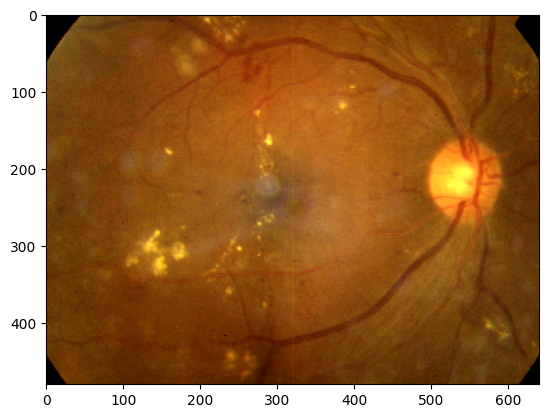

In [ ]:
classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
test_with_single_image(model, name, test_transforms, classes)


In [ ]:
for img_name in ['article1.jpg', '5b42aa87662e.png', '5b7aec374735.png']:
    test_with_single_image(model, os.path.join(test_dir, img_name), test_transforms, classes)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DR_Project/input/test_images/article1.jpg'